## Import modules

In [1]:
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot

In [2]:
import bisect as bs

In [3]:
from scipy.optimize import curve_fit

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)

In [4]:
import matplotlib as mpl
mpl.style.use('seaborn-bright')

## Global initialization

In [2]:
print(sys.version_info)

plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams.update({'font.size': 10})

numCuts = np.arange(0,6)

branch_path_gbm = 'SREffi_gbm'
branch_path_dsa = 'SREffi_dsa'

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)


In [3]:
all_plot_vars = ['metpt', 'jetpt','metjetphi', 'metmuphi', 'leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
plot_vars_metjet = all_plot_vars[0:4] #['metpt', 'jetpt', 'metjetphi', 'metmuphi']
plot_vars_muons = all_plot_vars[4:8] #['leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
cutflow_vars = ['cutflow_incl', 'cutflow_excl']
all_plot_xlabels = [
    'MET [GeV]', 'Leading jet pT [GeV]', '$\Delta\Phi$(MET, jet)', '$\Delta\Phi$(MET, di-muon)',
    'Leading muon pT [GeV]', 'Subleading muon pT [GeV]', 'dR(muons)', 'Di-muon vertex [cm]']

## Process signal

In [7]:
masses = [('60p0','20p0'),('6p0','2p0'),('52p5','5p0'),('5p25','0p5')]
def print_masses(mass):
    return f'({float(mass[0].replace("p","."))-float(mass[1].replace("p","."))/2}, ' + \
           f'{float(mass[0].replace("p","."))+float(mass[1].replace("p","."))/2}) GeV'
    
mchis = dict([(mass[0], print_masses(mass)) for mass in masses])
ctaus = [10]#, 10, 100, 1000]

labels = [ f'cut{cut}' for cut in numCuts ]
cut_descriptions = [
    'cut1: MET/MHT trigger fired (120 GeV)',
    'cut2: j1 pT > 120 GeV, <= 2j w/ pT > 30 GeV',
    'cut3: mu1 pT > 5 GeV, 0.1 < |dxy| < 700 cm',
    'cut4: mu2 pT > 5 GeV, 0.1 < |dxy| < 700 cm',
    r'cut5: $|\Delta\Phi$(MET, mu pair)| < 0.4',
]

base_dir = '../iDMSkimmer/washAOD/SROptimization/'
def filename(Mchi, dMchi, ctau): 
    return base_dir + f'Mchi-{Mchi}_dMchi-{dMchi}_ctau-{ctau}.root'

In [8]:
trees_gbm = dict()
trees_dsa = dict()
gen_info = dict()

In [7]:
redirector = 'root://cmseos.fnal.gov/'
base_dir = '/store/group/lpcmetx/iDM/Ntuples/2018/signal/iDMAnalysis'

samples = {
    '52p5': {
        'filename': redirector + base_dir + '/iDMAnalysis_Mchi-52p5_dMchi-5p0_ctau-100.root'
    },
    '5p25': {
        'filename': redirector + base_dir + '/iDMAnalysis_Mchi-5p25_dMchi-0p5_ctau-100.root'
    },
    '6p0': {
        'filename': redirector + base_dir + '/iDMAnalysis_Mchi-6p0_dMchi-2p0_ctau-100.root'
    },
    '60p0': {
        'filename': redirector + base_dir + '/iDMAnalysis_Mchi-60p0_dMchi-20p0_ctau-100.root'
    },
}

In [198]:
for sample, props in samples.items():
    file = uproot.open(props['filename'])
    props['tree_gen'] = file['SREffi_gbm/gen']
    props['tree_gbm'] = file['SREffi_gbm/reco']
    props['tree_dsa'] = file['SREffi_dsa/reco']

In [150]:
import ROOT

Welcome to JupyROOT 6.16/00


In [163]:
f = ROOT.TFile.Open("root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/iDMAnalysis/iDMAnalysis_Mchi-6p0_dMchi-2p0_ctau-100.root")

In [164]:
recoT = f.Get("SREffi_dsa/reco")
genT = f.Get("SREffi_dsa/gen")

In [172]:
recoT.GetEntry(0)

2086

In [179]:
count = 0
for i in range(5):
    recoT.GetEntry(i)
    genT.GetEntry(i)
    if (recoT.reco_mu_eta.size() > 0):
        for j in range(recoT.reco_mu_eta.size()):
            etadiff = abs(recoT.reco_mu_eta[j] - genT.gen_mu_eta[0])
            phidiff = abs(recoT.reco_mu_phi[j] - genT.gen_mu_phi[0])
            if phidiff > 3.141592:
                phidiff -= 2*3.141592
            dR = (phidiff**2 + etadiff**2)**(1/2)
            if (dR < 0.3):
                print('true')
                continue
            etadiff = abs(recoT.reco_mu_eta[j] - genT.gen_mu_eta[1])
            phidiff = abs(recoT.reco_mu_phi[j] - genT.gen_mu_phi[1])
            if phidiff > 3.141592:
                phidiff -= 2*3.141592
            dR = (phidiff**2 + etadiff**2)**(1/2)
            if (dR < 0.3):
                print('true')
                continue
            print('false')

false
false
false
true
true
false
true
true
false


In [139]:
gen_arrays = samples['6p0']['tree_gen'].arrays(['gen_mu_pt','gen_mu_eta','gen_mu_phi','gen_mu_vxy'], namedecode="utf-8")

In [159]:
jagged_reco[0

<Table [<Row 0> <Row 1> <Row 2>] at 0x7f0720b8b710>

In [101]:
from coffea.analysis_objects import JaggedCandidateArray

In [145]:
jagged_reco = JaggedCandidateArray.candidatesfromcounts(reco_arrays['reco_num_good_mu'],
                                                                 pt=reco_arrays['reco_mu_pt'].content,
                                                                 eta=reco_arrays['reco_mu_eta'].content,
                                                                 phi=reco_arrays['reco_mu_phi'].content,
                                                                 mass=0.1
)
jagged_gen = JaggedCandidateArray.candidatesfromcounts(np.repeat(2, len(gen_arrays['gen_mu_pt'])),
                                                                 pt=gen_arrays['gen_mu_pt'].content,
                                                                 eta=gen_arrays['gen_mu_eta'].content,
                                                                 phi=gen_arrays['gen_mu_phi'].content,
                                                                 mass=0.1
)

In [149]:
jagged_gen[1].tolist()

[{'p4': TLorentzVector(33.521, 2.0608, -2.6643, 0.1),
  '__fast_pt': 33.52093505859375,
  '__fast_eta': 2.060772180557251,
  '__fast_phi': -2.6643214225769043,
  '__fast_mass': 0.1},
 {'p4': TLorentzVector(5.8954, 2.0661, -2.7008, 0.1),
  '__fast_pt': 5.895386219024658,
  '__fast_eta': 2.066143035888672,
  '__fast_phi': -2.700788736343384,
  '__fast_mass': 0.1}]

In [188]:
matched = jagged_gen.argmatch(jagged_reco, deltaRCut=0.3)

In [196]:
jagged_gen[2].tolist()

[{'p4': TLorentzVector(3.7889, 0.88898, -1.6826, 0.1),
  '__fast_pt': 3.788881540298462,
  '__fast_eta': 0.8889760971069336,
  '__fast_phi': -1.6826186180114746,
  '__fast_mass': 0.1},
 {'p4': TLorentzVector(2.0967, 0.67447, -1.6138, 0.1),
  '__fast_pt': 2.09671950340271,
  '__fast_eta': 0.6744730472564697,
  '__fast_phi': -1.6138179302215576,
  '__fast_mass': 0.1}]

In [197]:
jagged_reco[1].tolist()

[{'p4': TLorentzVector(3.9609, 1.6804, -2.7128, 0.1),
  '__fast_pt': 3.9608969688415527,
  '__fast_eta': 1.6804112195968628,
  '__fast_phi': -2.712778091430664,
  '__fast_mass': 0.1},
 {'p4': TLorentzVector(2.5702, 2.0879, -2.0918, 0.1),
  '__fast_pt': 2.5701889991760254,
  '__fast_eta': 2.087947130203247,
  '__fast_phi': -2.0917632579803467,
  '__fast_mass': 0.1},
 {'p4': TLorentzVector(2.2113, -1.9062, 2.5427, 0.1),
  '__fast_pt': 2.211280107498169,
  '__fast_eta': -1.9061734676361084,
  '__fast_phi': 2.5427165031433105,
  '__fast_mass': 0.1}]

In [190]:
matched.tolist()

[[],
 [-1, -1],
 [0, 0],
 [0, 0],
 [1, 0],
 [-1, -1],
 [],
 [2, 0],
 [0, -1],
 [-1, -1],
 [0, 0],
 [-1, -1],
 [-1, -1],
 [0, 1],
 [-1, -1],
 [0, -1],
 [],
 [],
 [0, -1],
 [],
 [0, 0],
 [-1, -1],
 [0, 1],
 [0, 0],
 [0, 0],
 [],
 [0, 1],
 [],
 [0, 0],
 [1, 0],
 [-1, 0],
 [0, 0],
 [0, 0],
 [-1, 0],
 [0, 0],
 [-1, -1],
 [0, 0],
 [-1, -1],
 [-1, -1],
 [1, 0],
 [-1, -1],
 [],
 [-1, -1],
 [1, 0],
 [0, 0],
 [],
 [1, 0],
 [],
 [],
 [],
 [0, 0],
 [-1, -1],
 [],
 [1, 0],
 [],
 [-1, -1],
 [0, 0],
 [-1, -1],
 [],
 [0, 0],
 [1, 0],
 [0, 0],
 [0, 0],
 [-1, -1],
 [0, 0],
 [-1, 2],
 [0, 0],
 [0, 0],
 [-1, -1],
 [0, 0],
 [0, 0],
 [0, 0],
 [-1, -1],
 [0, 0],
 [],
 [],
 [0, 0],
 [0, 0],
 [0, 0],
 [-1, -1],
 [1, 1],
 [0, 1],
 [0, 0],
 [-1, 0],
 [-1, 0],
 [-1, -1],
 [0, 1],
 [0, 0],
 [-1, -1],
 [0, -1],
 [0, 1],
 [0, 0],
 [0, 0],
 [1, 1],
 [0, 1],
 [0, 0],
 [-1, -1],
 [],
 [-1, -1],
 [],
 [0, -1],
 [0, 0],
 [-1, -1],
 [-1, 0],
 [0, 0],
 [0, -1],
 [-1, -1],
 [-1, 0],
 [0, 0],
 [0, -1],
 [-1, 0],
 [0, 0],
 [-

In [140]:
reco_arrays = samples['6p0']['tree_dsa'].arrays(['reco_num_good_mu','reco_mu_pt','reco_mu_eta','reco_mu_phi','reco_vertex_vxy'], namedecode="utf-8")

In [98]:
test_df['gen_mu_eta']

<JaggedArray [[2.5695903 2.638479] [2.0607722 2.066143] [0.8889761 0.67447305] ... [2.017914 2.012785] [-0.24208345 -0.12223266] [0.019464862 0.37301174]] at 0x7f06c02756a0>

In [99]:
test_df2['reco_mu_eta']

<JaggedArray [[] [1.6804112 2.0879471 -1.9061735] [0.92215836] ... [1.9897128 2.026989] [-0.13518967] [0.37512043]] at 0x7f06c02ac4e0>

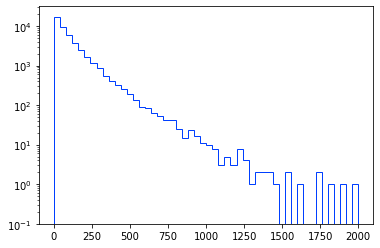

In [81]:
plt.hist(test_df['gen_mu_vxy'][:,0], bins=50, log=True, range=(0,2000), histtype='step');

In [48]:
samples['6p0']['tree_gen'].show()

gen_pu_obs                 (no streamer)              asdtype('>i4')
gen_pu_true                (no streamer)              asdtype('>i4')
gen_wgt                    (no streamer)              asdtype('>f4')
gen_mu_pt                  TStreamerSTL               asjagged(asdtype('>f4'), 10)
gen_mu_eta                 TStreamerSTL               asjagged(asdtype('>f4'), 10)
gen_mu_phi                 TStreamerSTL               asjagged(asdtype('>f4'), 10)
gen_mu_energy              TStreamerSTL               asjagged(asdtype('>f4'), 10)
gen_mu_dR                  TStreamerSTL               asjagged(asdtype('>f4'), 10)
gen_mu_vxy                 TStreamerSTL               asjagged(asdtype('>f4'), 10)
gen_mu_vz                  TStreamerSTL               asjagged(asdtype('>f4'), 10)
gen_chi1_pt                TStreamerSTL               asjagged(asdtype('>f4'), 10)
gen_chi1_eta               TStreamerSTL               asjagged(asdtype('>f4'), 10)
gen_chi1_phi               TStreamerSTL       

In [18]:
samples['6p0']['tree_dsa'].show()

trig_fired                 (no streamer)              asdtype('>u4')
reco_mu_pt                 TStreamerSTL               asjagged(asdtype('>f4'), 10)
reco_mu_eta                TStreamerSTL               asjagged(asdtype('>f4'), 10)
reco_mu_phi                TStreamerSTL               asjagged(asdtype('>f4'), 10)
reco_mu_dxy                TStreamerSTL               asjagged(asdtype('>f4'), 10)
reco_mu_dz                 TStreamerSTL               asjagged(asdtype('>f4'), 10)
reco_mu_M2                 (no streamer)              asdtype('>f4')
reco_num_mu                (no streamer)              asdtype('>i4')
reco_num_good_mu           (no streamer)              asdtype('>i4')
reco_MET_mu_DeltaPhi       (no streamer)              asdtype('>f4')
reco_vertex_vxy            TStreamerSTL               asjagged(asdtype('>f4'), 10)
reco_vertex_vz             TStreamerSTL               asjagged(asdtype('>f4'), 10)
reco_vertex_dR             TStreamerSTL               asjagged(asdtype('>f

In [199]:
for sample, props in samples.items():
    props['combined_df_dsa'] = pd.concat([
        props['tree_dsa'].pandas.df('reco_vertex_vxy').groupby('entry').max(), 
        props['tree_gen'].pandas.df('gen_mu_vxy').groupby('entry').max()], axis=1
    ).dropna()
    props['combined_df_gbm'] = pd.concat([
        props['tree_gbm'].pandas.df('reco_vertex_vxy').groupby('entry').max(), 
        props['tree_gen'].pandas.df('gen_mu_vxy').groupby('entry').max()], axis=1
    ).dropna()

In [200]:
samples['52p5']['fit_low_dsa'] = -10
samples['52p5']['fit_high_dsa'] = 20
samples['52p5']['fit_gbm'] = 'yes'
samples['52p5']['fit_low_gbm'] = -70
samples['52p5']['fit_high_gbm'] = 70
samples['52p5']['color'] = 'C1'
samples['52p5']['label'] = 'm1 = 50 GeV, $\Delta = 0.1$'

samples['5p25']['fit_low_dsa'] = -10
samples['5p25']['fit_high_dsa'] = 20
samples['5p25']['fit_gbm'] = 'no'
samples['5p25']['color'] = 'C0'
samples['5p25']['label'] = 'm1 = 5 GeV, $\Delta = 0.1$'

samples['6p0']['fit_low_dsa'] = -10
samples['6p0']['fit_high_dsa'] = 20
samples['6p0']['fit_gbm'] = 'no'
samples['6p0']['color'] = 'C2'
samples['6p0']['label'] = 'm1 = 5 GeV, $\Delta = 0.4$'

samples['60p0']['fit_low_dsa'] = -5
samples['60p0']['fit_high_dsa'] = 10
samples['60p0']['fit_gbm'] = 'yes'
samples['60p0']['fit_low_gbm'] = -30
samples['60p0']['fit_high_gbm'] = 30
samples['60p0']['color'] = 'C3'
samples['60p0']['label'] = 'm1 = 50 GeV, $\Delta = 0.4$'

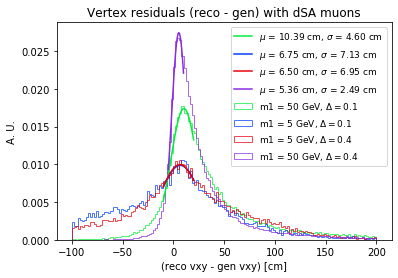

In [201]:
for index, (sample, props) in enumerate(samples.items()):
    nbins, edges, _ = plt.hist((props['combined_df_dsa']['reco_vertex_vxy'] - props['combined_df_dsa']['gen_mu_vxy']),
                               bins=150, histtype='step', range=(-100,200), density=True, 
                               alpha=0.7, color=props['color'], label=props['label']);
    bin_centers = (edges[:-1] + edges[1:])/2
    fit_bin_low = bs.bisect_right(bin_centers, props['fit_low_dsa'])
    fit_bin_high = bs.bisect_left(bin_centers, props['fit_high_dsa'])
    popt, pcov = curve_fit(gaussian,
                       xdata=bin_centers[fit_bin_low : fit_bin_high],
                       ydata=nbins[fit_bin_low : fit_bin_high])
    fit_range = np.linspace(props['fit_low_dsa'], props['fit_high_dsa'], 1000)
    plt.plot(fit_range, gaussian(fit_range, *popt), c=props['color'],
             label=f'$\mu$ = {popt[1]:.2f} cm, $\sigma$ = {popt[2]:.2f} cm')
    plt.xlabel('(reco vxy - gen vxy) [cm]')
    plt.ylabel('A. U.')
#     plt.text(0.98,0.8-index*0.1, f'$\mu$ = {popt[1]:.2f} cm, $\sigma$ = {popt[2]:.2f} cm',
#              ha='right', va='top', transform = plt.gca().transAxes,
#              bbox=dict(boxstyle="round",
#                    ec=props['color'],
#                    fc='white'
#              )
#     )
    
plt.title('Vertex residuals (reco - gen) with dSA muons')
plt.legend(loc='upper right', fontsize=9);

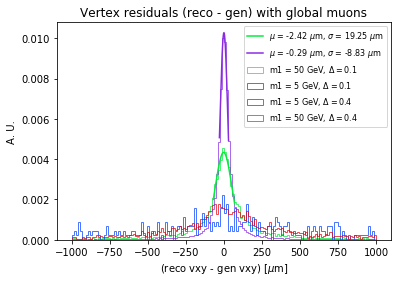

In [202]:
for sample, props in samples.items():
    nbins, edges, _ = plt.hist(10**4*(props['combined_df_gbm']['reco_vertex_vxy'] - props['combined_df_gbm']['gen_mu_vxy']),
                               bins=150, histtype='step', range=(-1000,1000), density=True, 
                               alpha=0.7, color=props['color'], label=props['label']);
    
    if props['fit_gbm'] == 'no': continue
        
    bin_centers = (edges[:-1] + edges[1:])/2
    fit_bin_low = bs.bisect_right(bin_centers, props['fit_low_gbm'])
    fit_bin_high = bs.bisect_left(bin_centers, props['fit_high_gbm'])
    popt, pcov = curve_fit(gaussian,
                       xdata=bin_centers[fit_bin_low : fit_bin_high],
                       ydata=nbins[fit_bin_low : fit_bin_high],
                       p0=(1,0, 19))
    fit_range = np.linspace(props['fit_low_gbm'], props['fit_high_gbm'], 1000)
    plt.plot(fit_range, gaussian(fit_range, *popt), c=props['color'],
            label=f'$\mu$ = {popt[1]:.2f} $\mu$m, $\sigma$ = {popt[2]:.2f} $\mu$m')
    plt.xlabel(r'(reco vxy - gen vxy) [$\mu$m]')
    plt.ylabel('A. U.')
#     plt.text(0.98,0.95, f'$\mu$ = {popt[1]:.2f} $\mu$m, $\sigma$ = {popt[2]:.2f} $\mu$m',
#              ha='right', va='top', transform = plt.gca().transAxes,
#              bbox=dict(boxstyle="round",
#                    ec='orange',
#                    fc='white'
#              )
#     )

plt.title('Vertex residuals (reco - gen) with global muons')
plt.legend(loc='upper right', fontsize=8);

Text(0.5, 1.0, 'dsa muons')

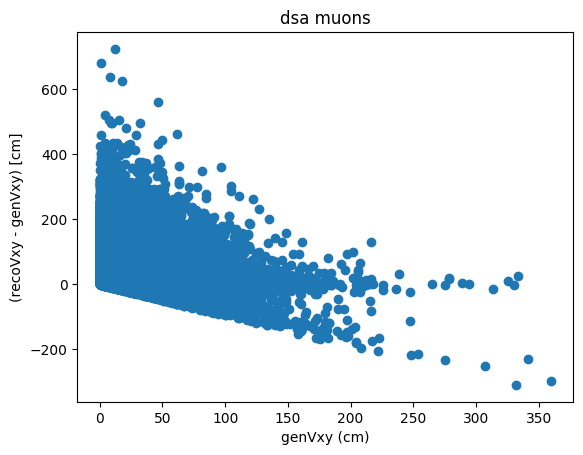

In [103]:
plt.scatter(combined['vertex_vxy'], (combined[0] - combined['vertex_vxy']), 
 label='dsa muons');
plt.xlabel('genVxy (cm)')
plt.ylabel('(recoVxy - genVxy) [cm]')
# plt.xlim([0,100])
plt.title('dsa muons')

In [9]:
num_params = len(masses)*len(ctaus)
count_param = 1

for (Mchi, dMchi) in masses:
    trees_gbm[Mchi] = dict()
    trees_dsa[Mchi] = dict()
    gen_info[Mchi] = dict()
    for ctau in ctaus:
        gen_info[Mchi][ctau] = uproot.open(filename(Mchi, dMchi, ctau))['GEN/gen']#.pandas.df(flatten=False)
        trees_gbm[Mchi][ctau] = uproot.open(filename(Mchi, dMchi, ctau))[branch_path_gbm + f'/cutsTree']#.pandas.df(flatten=False)
        trees_dsa[Mchi][ctau] = uproot.open(filename(Mchi, dMchi, ctau))[branch_path_dsa + f'/cutsTree']#.pandas.df(flatten=False)
        print(f'{count_param} of {num_params}: ' + filename(Mchi, dMchi, ctau))
        count_param += 1

1 of 4: ../iDMSkimmer/washAOD/SROptimization/Mchi-60p0_dMchi-20p0_ctau-10.root
2 of 4: ../iDMSkimmer/washAOD/SROptimization/Mchi-6p0_dMchi-2p0_ctau-10.root
3 of 4: ../iDMSkimmer/washAOD/SROptimization/Mchi-52p5_dMchi-5p0_ctau-10.root
4 of 4: ../iDMSkimmer/washAOD/SROptimization/Mchi-5p25_dMchi-0p5_ctau-10.root


In [10]:
pd.concat([trees_dsa['5p25'][10].pandas.df('recoVxy').groupby('entry').max()['recoVxy'], 
           gen_info['5p25'][10].pandas.df('vxy').groupby('entry').max()['vxy']], axis=1).dropna()

,recoVxy,vxy
entry,,
2,26.404278,6.676163
4,58.652882,56.346612
8,0.000000,23.678391
24,90.384911,31.936306
29,4.528256,8.269389
36,19.760229,3.876395
37,0.000000,6.313950
48,3.996315,61.031816
54,54.316971,54.412538


Text(0.5, 1.0, 'dSA muons')

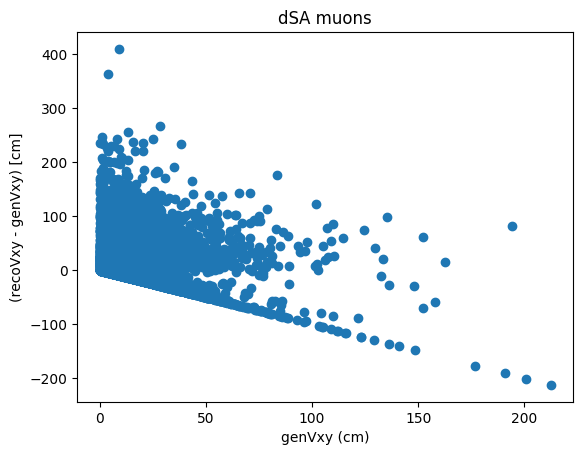

In [14]:
plt.scatter(pd.concat([trees_dsa['5p25'][10].pandas.df('recoVxy').groupby('entry').max()['recoVxy'],
gen_info['5p25'][10].pandas.df('vxy').groupby('entry').max()['vxy']], axis=1).dropna()['vxy'],
    (trees_dsa['5p25'][10].pandas.df('recoVxy').groupby('entry').max()['recoVxy'] - \
gen_info['5p25'][10].pandas.df('vxy').groupby('entry').max()['vxy']).dropna(), 
 label='dSA muons');
plt.xlabel('genVxy (cm)')
plt.ylabel('(recoVxy - genVxy) [cm]')
# plt.ylim([0,100])
plt.title('dSA muons')

In [31]:
trees_gbm['5p25'][10].pandas.df('recoVxy').groupby('entry').max().query('recoVxy>0.001')

,recoVxy
entry,
2,6.798852
24,0.135972
29,8.345621
36,3.799904
37,6.495319
48,0.061179
90,12.918693
108,13.195795
118,3.516287


In [32]:
pd.concat([trees_gbm['5p25'][10].pandas.df('recoVxy').groupby('entry').max().query('recoVxy>0.001'),
gen_info['5p25'][10].pandas.df('vxy').groupby('entry').max()['vxy']], axis=1).dropna()

,recoVxy,vxy
entry,,
2,6.798852,6.676163
24,0.135972,31.936306
29,8.345621,8.269389
36,3.799904,3.876395
37,6.495319,6.313950
48,0.061179,61.031816
90,12.918693,11.970212
108,13.195795,11.671849
118,3.516287,3.515535


Text(0.5, 1.0, 'global muons')

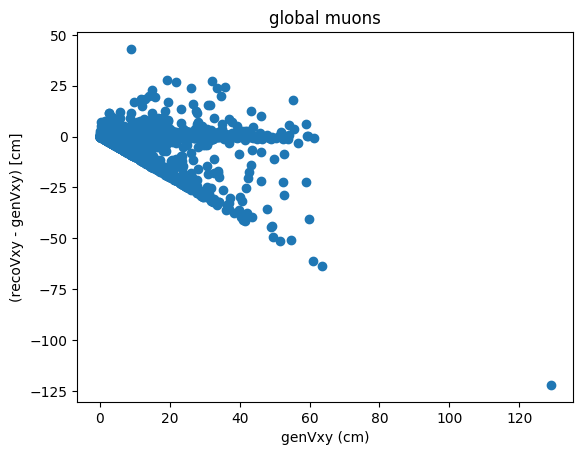

In [33]:
plt.scatter(pd.concat([trees_gbm['5p25'][10].pandas.df('recoVxy').groupby('entry').max().query('recoVxy>0.001')['recoVxy'],
gen_info['5p25'][10].pandas.df('vxy').groupby('entry').max()['vxy']], axis=1).dropna()['vxy'],
    (trees_gbm['5p25'][10].pandas.df('recoVxy').groupby('entry').max().query('recoVxy>0.001')['recoVxy'] - \
gen_info['5p25'][10].pandas.df('vxy').groupby('entry').max()['vxy']).dropna(), 
 label='gBM muons');
plt.xlabel('genVxy (cm)')
plt.ylabel('(recoVxy - genVxy) [cm]')
plt.title('global muons')

(-100, 300)

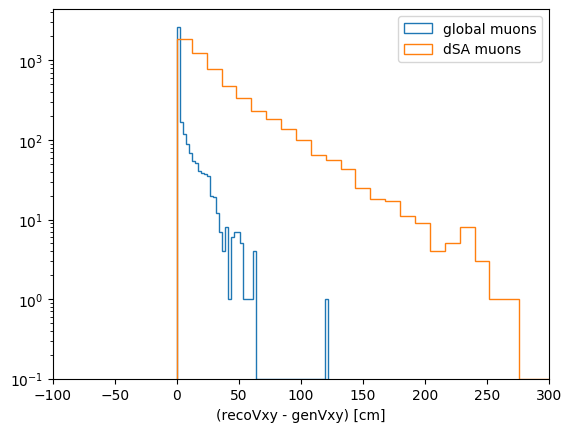

In [38]:
plt.hist((np.abs(trees_gbm['5p25'][10].pandas.df('recoVxy').groupby('entry').max()['recoVxy'] - \
gen_info['5p25'][10].pandas.df('vxy').groupby('entry').max()['vxy']).dropna()), label='global muons', bins=50, log=True, histtype='step');

plt.hist(np.abs((trees_dsa['5p25'][10].pandas.df('recoVxy').groupby('entry').max()['recoVxy'] - \
gen_info['5p25'][10].pandas.df('vxy').groupby('entry').max()['vxy']).dropna()), label='dSA muons', bins=50, range=(0,600), log=True, histtype='step');

plt.xlabel('(recoVxy - genVxy) [cm]')
plt.legend()
plt.xlim([-100,300])

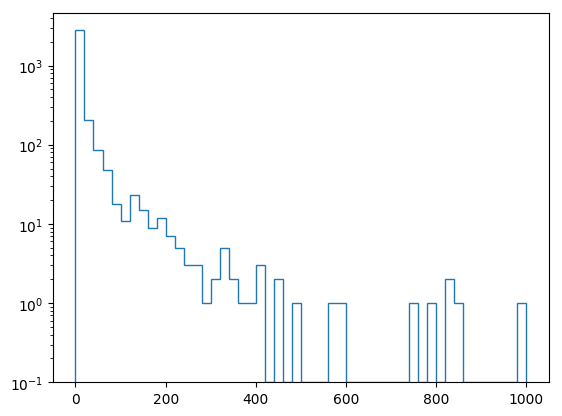

In [21]:
plt.hist(((trees_dsa['5p25'][10].pandas.df('recoVxy').groupby('entry').max()['recoVxy'] - \
gen_info['5p25'][10].pandas.df('vxy').groupby('entry').max()['vxy'])/ \
gen_info['5p25'][10].pandas.df('vxy').groupby('entry').max()['vxy']).dropna(), bins=50, range=(0,1000), log=True, histtype='step');

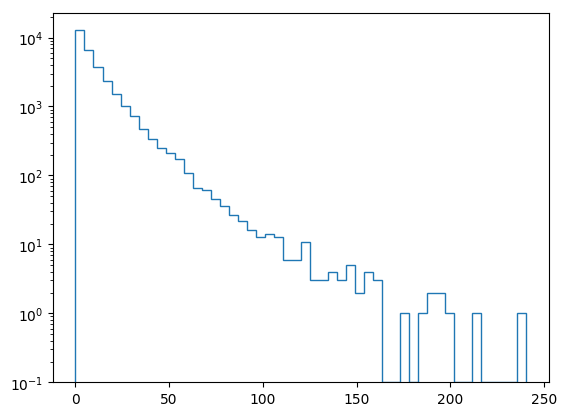

In [22]:
plt.hist(gen_info['5p25'][10].pandas.df('vxy').groupby('entry').max()['vxy'], bins=50, log=True, histtype='step');